In [39]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar100
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import itertools
import os
import shutil
import torch
import random
import glob
import matplotlib.pyplot as plt
import warnings
import tensorflow.keras.applications.efficientnet as efn
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

In [3]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.7)

In [4]:
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True, preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

In [12]:
# Dataset class labels
labels =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
           'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
           'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
           'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
           'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
           'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
           'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
           'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
           'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

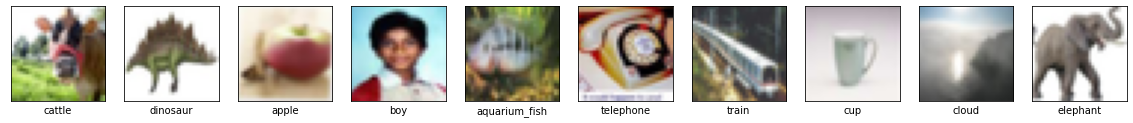

In [13]:
# Visualize several images and their classes from the training set
plt.figure(figsize=(20, 3))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap="gray")
    plt.xlabel(labels[y_train[i].astype(int)[0]])
    
plt.show()

In [15]:
# Convert labels to one hot encoding matrix
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)
y_valid = to_categorical(y_valid, 100)

In [17]:
model = Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(32,32,3)),
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),
    
    
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),    
    Dropout(0.2),
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Dropout(0.2),
    
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Dropout(0.2),
    
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dropout(0.5),

    Dense(units=100, activation='softmax')
])
print(model.summary())
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
filepath1="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
filepath2 = "best_weights.hdf5"
checkpoint1 = ModelCheckpoint(filepath1, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


callbacks_list = [checkpoint1,checkpoint2]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 conv2d_14 (Conv2D)          (None, 32, 32, 16)        2320      
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 32)       

In [19]:
TRAIN_STEPS_PER_EPOCH = np.ceil((len(X_train)/16))
VAL_STEPS_PER_EPOCH = np.ceil((len(X_valid)/16))
model.fit(
         datagen.flow(X_train, y_train, batch_size=16),
         validation_data=datagen.flow(X_valid, y_valid, batch_size=16),
         steps_per_epoch = TRAIN_STEPS_PER_EPOCH,
         validation_steps = VAL_STEPS_PER_EPOCH,
         epochs=150,
         callbacks=callbacks_list
)

Epoch 1/150
3123/3125 [============================>.] - ETA: 0s - loss: 1.7042 - accuracy: 0.5296
Epoch 00001: val_accuracy did not improve from 0.48057

Epoch 00001: val_accuracy did not improve from 0.48057
3125/3125 [==============================] - 32s 10ms/step - loss: 1.7041 - accuracy: 0.5297 - val_loss: 2.0423 - val_accuracy: 0.4734
Epoch 2/150
3124/3125 [============================>.] - ETA: 0s - loss: 1.6831 - accuracy: 0.5363
Epoch 00002: val_accuracy did not improve from 0.48057

Epoch 00002: val_accuracy did not improve from 0.48057
3125/3125 [==============================] - 35s 11ms/step - loss: 1.6832 - accuracy: 0.5364 - val_loss: 2.0467 - val_accuracy: 0.4781
Epoch 3/150
3123/3125 [============================>.] - ETA: 0s - loss: 1.6731 - accuracy: 0.5379
Epoch 00003: val_accuracy did not improve from 0.48057

Epoch 00003: val_accuracy did not improve from 0.48057
3125/3125 [==============================] - 33s 10ms/step - loss: 1.6730 - accuracy: 0.5379 - val_l

3123/3125 [============================>.] - ETA: 0s - loss: 1.3959 - accuracy: 0.6049
Epoch 00023: val_accuracy did not improve from 0.50643

Epoch 00023: val_accuracy did not improve from 0.50643
3125/3125 [==============================] - 33s 10ms/step - loss: 1.3960 - accuracy: 0.6049 - val_loss: 2.0508 - val_accuracy: 0.4993
Epoch 24/150
3122/3125 [============================>.] - ETA: 0s - loss: 1.3791 - accuracy: 0.6087
Epoch 00024: val_accuracy did not improve from 0.50643

Epoch 00024: val_accuracy did not improve from 0.50643
3125/3125 [==============================] - 33s 11ms/step - loss: 1.3790 - accuracy: 0.6087 - val_loss: 2.0676 - val_accuracy: 0.4966
Epoch 25/150
3121/3125 [============================>.] - ETA: 0s - loss: 1.3598 - accuracy: 0.6131
Epoch 00025: val_accuracy did not improve from 0.50643

Epoch 00025: val_accuracy did not improve from 0.50643
3125/3125 [==============================] - 33s 10ms/step - loss: 1.3600 - accuracy: 0.6131 - val_loss: 2.068

KeyboardInterrupt: 

In [ ]:
# I stopped the training progress because the validation accuracy didn't improve. 
# As you can see the accuracy is not so good. 
# So I decided to use transfer learning methods. 
# I will use Resnet.

In [26]:
def build_model(n_classes):
    """
    Build model from ResNet152. Retrain last 5 layers and adds 2 Dense layers.
    :param input_shape: shape of single image
    :param n_classes: number of classes for prediction
    :return model: compiled model
    """
    base_model = tf.keras.applications.ResNet152(input_shape=(32,32,3),
                                      weights="imagenet",
                                      include_top=False,
                                      pooling='avg')

    for layer in base_model.layers[:-5]:
        layer.trainable = False

    for layer in base_model.layers[-5:]:
        layer.trainable = True

    x = base_model.output
    
    
    x = Dense(128)(x)
    x = Activation('relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [29]:
model = build_model(n_classes=100)

In [30]:
TRAIN_STEPS_PER_EPOCH = np.ceil((len(X_train)/16))
VAL_STEPS_PER_EPOCH = np.ceil((len(X_valid)/16))
model.fit(
         datagen.flow(X_train, y_train, batch_size=16),
         validation_data=datagen.flow(X_valid, y_valid, batch_size=16),
         steps_per_epoch = TRAIN_STEPS_PER_EPOCH,
         validation_steps = VAL_STEPS_PER_EPOCH,
         epochs=150,
         callbacks=callbacks_list
)

Epoch 1/150
3124/3125 [============================>.] - ETA: 0s - loss: 3.1891 - accuracy: 0.2409
Epoch 00001: val_accuracy did not improve from 0.50643

Epoch 00001: val_accuracy did not improve from 0.50643
3125/3125 [==============================] - 148s 45ms/step - loss: 3.1888 - accuracy: 0.2410 - val_loss: 2.8884 - val_accuracy: 0.2889
Epoch 2/150
3125/3125 [==============================] - ETA: 0s - loss: 2.7013 - accuracy: 0.3160
Epoch 00002: val_accuracy did not improve from 0.50643

Epoch 00002: val_accuracy did not improve from 0.50643
3125/3125 [==============================] - 136s 44ms/step - loss: 2.7013 - accuracy: 0.3160 - val_loss: 2.7264 - val_accuracy: 0.3206
Epoch 3/150
3124/3125 [============================>.] - ETA: 0s - loss: 2.5638 - accuracy: 0.3455
Epoch 00003: val_accuracy did not improve from 0.50643

Epoch 00003: val_accuracy did not improve from 0.50643
3125/3125 [==============================] - 139s 45ms/step - loss: 2.5637 - accuracy: 0.3455 - va

KeyboardInterrupt: 

In [31]:
#  I stopped this progress too. XD
#  This progress takes a lot of time without any difference in the accuracy.
#  So what we can do to improve our accuracy?
#  Lets change our first model.

In [37]:
model2 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(32,32,3)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),
    
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),    
    Dropout(0.1),
    
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Dropout(0.2),
    
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Dropout(0.2),
    
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dropout(0.5),

    Dense(units=100, activation='softmax')
])
print(model2.summary())
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
filepath1="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
filepath2 = "best_weights.hdf5"
checkpoint1 = ModelCheckpoint(filepath1, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


callbacks_list = [checkpoint1,checkpoint2]

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_65 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_66 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_20 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_68 (Conv2D)          (None, 16, 16, 64)       

In [38]:
TRAIN_STEPS_PER_EPOCH = np.ceil((len(X_train)/16))
VAL_STEPS_PER_EPOCH = np.ceil((len(X_valid)/16))
model2.fit(
         datagen.flow(X_train, y_train, batch_size=16),
         validation_data=datagen.flow(X_valid, y_valid, batch_size=16),
         steps_per_epoch = TRAIN_STEPS_PER_EPOCH,
         validation_steps = VAL_STEPS_PER_EPOCH,
         epochs=150,
         callbacks=callbacks_list
)

Epoch 1/150
3125/3125 [==============================] - ETA: 0s - loss: 4.2182 - accuracy: 0.0461
Epoch 00001: val_accuracy improved from -inf to 0.10071, saving model to weights-improvement-01-0.10.hdf5

Epoch 00001: val_accuracy improved from -inf to 0.10071, saving model to best_weights.hdf5
3125/3125 [==============================] - 46s 14ms/step - loss: 4.2182 - accuracy: 0.0461 - val_loss: 3.7910 - val_accuracy: 0.1007
Epoch 2/150
3122/3125 [============================>.] - ETA: 0s - loss: 3.7089 - accuracy: 0.1155
Epoch 00002: val_accuracy improved from 0.10071 to 0.16057, saving model to weights-improvement-02-0.16.hdf5

Epoch 00002: val_accuracy improved from 0.10071 to 0.16057, saving model to best_weights.hdf5
3125/3125 [==============================] - 44s 14ms/step - loss: 3.7087 - accuracy: 0.1154 - val_loss: 3.4506 - val_accuracy: 0.1606
Epoch 3/150
3123/3125 [============================>.] - ETA: 0s - loss: 3.4290 - accuracy: 0.1640
Epoch 00003: val_accuracy impro

Epoch 21/150
3125/3125 [==============================] - ETA: 0s - loss: 1.7751 - accuracy: 0.5126
Epoch 00021: val_accuracy improved from 0.47571 to 0.48257, saving model to weights-improvement-21-0.48.hdf5

Epoch 00021: val_accuracy improved from 0.47571 to 0.48257, saving model to best_weights.hdf5
3125/3125 [==============================] - 43s 14ms/step - loss: 1.7751 - accuracy: 0.5126 - val_loss: 1.9421 - val_accuracy: 0.4826
Epoch 22/150
3123/3125 [============================>.] - ETA: 0s - loss: 1.7351 - accuracy: 0.5202
Epoch 00022: val_accuracy did not improve from 0.48257

Epoch 00022: val_accuracy did not improve from 0.48257
3125/3125 [==============================] - 43s 14ms/step - loss: 1.7351 - accuracy: 0.5202 - val_loss: 2.0050 - val_accuracy: 0.4803
Epoch 23/150
3124/3125 [============================>.] - ETA: 0s - loss: 1.6941 - accuracy: 0.5336
Epoch 00023: val_accuracy improved from 0.48257 to 0.49786, saving model to weights-improvement-23-0.50.hdf5

Epoch

Epoch 42/150
3122/3125 [============================>.] - ETA: 0s - loss: 1.0814 - accuracy: 0.6821
Epoch 00042: val_accuracy did not improve from 0.53529

Epoch 00042: val_accuracy did not improve from 0.53529
3125/3125 [==============================] - 44s 14ms/step - loss: 1.0815 - accuracy: 0.6820 - val_loss: 1.8811 - val_accuracy: 0.5346
Epoch 43/150
3122/3125 [============================>.] - ETA: 0s - loss: 1.0437 - accuracy: 0.6919
Epoch 00043: val_accuracy improved from 0.53529 to 0.53743, saving model to weights-improvement-43-0.54.hdf5

Epoch 00043: val_accuracy improved from 0.53529 to 0.53743, saving model to best_weights.hdf5
3125/3125 [==============================] - 43s 14ms/step - loss: 1.0438 - accuracy: 0.6918 - val_loss: 1.8958 - val_accuracy: 0.5374
Epoch 44/150
3123/3125 [============================>.] - ETA: 0s - loss: 1.0188 - accuracy: 0.6994
Epoch 00044: val_accuracy improved from 0.53743 to 0.54329, saving model to weights-improvement-44-0.54.hdf5

Epoch

Epoch 65/150
3125/3125 [==============================] - ETA: 0s - loss: 0.6319 - accuracy: 0.8073
Epoch 00065: val_accuracy did not improve from 0.54843

Epoch 00065: val_accuracy did not improve from 0.54843
3125/3125 [==============================] - 42s 13ms/step - loss: 0.6319 - accuracy: 0.8073 - val_loss: 2.2433 - val_accuracy: 0.5473
Epoch 66/150
3121/3125 [============================>.] - ETA: 0s - loss: 0.6136 - accuracy: 0.8132
Epoch 00066: val_accuracy improved from 0.54843 to 0.55014, saving model to weights-improvement-66-0.55.hdf5

Epoch 00066: val_accuracy improved from 0.54843 to 0.55014, saving model to best_weights.hdf5
3125/3125 [==============================] - 42s 13ms/step - loss: 0.6137 - accuracy: 0.8132 - val_loss: 2.2310 - val_accuracy: 0.5501
Epoch 67/150
3122/3125 [============================>.] - ETA: 0s - loss: 0.6132 - accuracy: 0.8150
Epoch 00067: val_accuracy did not improve from 0.55014

Epoch 00067: val_accuracy did not improve from 0.55014
3125

Epoch 88/150
3125/3125 [==============================] - ETA: 0s - loss: 0.4270 - accuracy: 0.8716
Epoch 00088: val_accuracy did not improve from 0.55314

Epoch 00088: val_accuracy did not improve from 0.55314
3125/3125 [==============================] - 42s 13ms/step - loss: 0.4270 - accuracy: 0.8716 - val_loss: 2.5251 - val_accuracy: 0.5470
Epoch 89/150
3122/3125 [============================>.] - ETA: 0s - loss: 0.4216 - accuracy: 0.8718
Epoch 00089: val_accuracy did not improve from 0.55314

Epoch 00089: val_accuracy did not improve from 0.55314
3125/3125 [==============================] - 42s 13ms/step - loss: 0.4216 - accuracy: 0.8718 - val_loss: 2.5212 - val_accuracy: 0.5461
Epoch 90/150
3122/3125 [============================>.] - ETA: 0s - loss: 0.4153 - accuracy: 0.8747
Epoch 00090: val_accuracy did not improve from 0.55314

Epoch 00090: val_accuracy did not improve from 0.55314
3125/3125 [==============================] - 42s 13ms/step - loss: 0.4152 - accuracy: 0.8747 - va

KeyboardInterrupt: 

In [ ]:
#    Again. I stopped this progress because as we can see the model gets overfitted.
#    We recived high train accuracy so we must do st to prevent overfitting.
#    Lets use KFold Cross Validation.

In [ ]:
Again. I stopped this progress because as we can see the model is overfitted. We received high train accuracy so we must do st to prevent overfitting. Lets use KFold Cross Validation.

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)
acc_per_fold = []
loss_per_fold = []
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
    model3 = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(32,32,3)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),
    
    
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),    
    Dropout(0.1),
    
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Dropout(0.2),
    
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding = 'same'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Dropout(0.2),
    
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding = 'same'),
    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dropout(0.5),

    Dense(units=100, activation='softmax')
    ])
    model3.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])



    # Generate a print
    print('------------------------------------------------------------------------')
  
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model3.fit(datagen.flow(inputs[train], targets[train]),
                batch_size=16,
                epochs=50,
                
                )

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

In [ ]:
#   I used this method and trained data but this progress doesn't work neither.